# Analyze gaps fluxnet

In [ ]:
from IPython.display import display
from ipywidgets import widgets, interact

In [ ]:
from pathlib import Path
import polars as pl
from datetime import datetime
from fastcore.utils import * # support of ls for paths
import matplotlib.pyplot as plt
import altair as alt

In [ ]:
out_dir = Path("../../fluxnet/gap_stat")
download_dir = Path("/run/media/simone/Simone DATI/fluxnet_all")

In [ ]:
site_info = pl.read_parquet(out_dir / "../site_info.parquet").select([
    pl.col("start").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("end").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("site").cast(pl.Categorical).sort()
])

In [ ]:
site_info.head()

start,end,site
datetime[μs],datetime[μs],cat
2009-01-01 00:30:00,2012-01-01 00:00:00,"""AR-SLu"""
2009-01-01 00:30:00,2013-01-01 00:00:00,"""AR-Vir"""
2002-01-01 00:30:00,2013-01-01 00:00:00,"""AT-Neu"""
2007-01-01 00:30:00,2010-01-01 00:00:00,"""AU-Ade"""
2010-01-01 00:30:00,2015-01-01 00:00:00,"""AU-ASM"""


In [ ]:
def duration_n_obs(duration):
    "converts a duration into a n of fluxnet observations"
    return abs(int(duration.total_seconds() / (30 * 60)))

In [ ]:
duration_n_obs(site_info[1, "start"] - site_info[1, "end"])

70127

In [ ]:
duration_n_obs(site_info[0, "start"] - site_info[0, "end"])

52559

In [ ]:
site_info.select((pl.col("end")-pl.col("start")).dt.minutes() // 30).sum()

end
i64
26175287


In [ ]:
sp = site_info.to_pandas()

In [ ]:
((sp.end - sp.start).dt.total_seconds() / (30*60)).astype(int).sum()

26175287

In [ ]:
# maybe this code should actually go in 20_gap_finding
files = out_dir.ls()
files.sort() # need to sort to match the site_info
sites = []
for i, path in enumerate(files):
    sites.append(pl.scan_parquet(path).with_columns([
        pl.lit(site_info[i, "site"]).alias("site"),
        pl.lit(duration_n_obs(site_info[i, "start"] -  site_info[i, "end"])).alias("total_obs"),
        pl.col("TIMESTAMP_END").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M").alias("end"),
    ]).drop("TIMESTAMP_END"))

In [ ]:
gap_stat = pl.concat(sites)

In [ ]:
gap_stat.head().fetch(5)

gap_len,variable,site,total_obs,end
u32,str,str,i32,datetime[μs]
16992,"""TA_F_MDS_QC""","""AR-SLu""",52559,2009-01-01 00:30:00
5,"""TA_F_MDS_QC""","""AR-SLu""",52559,2009-12-21 11:00:00
1,"""TA_F_MDS_QC""","""AR-SLu""",52559,2009-12-21 17:00:00
1,"""TA_F_MDS_QC""","""AR-SLu""",52559,2010-01-06 13:00:00
3,"""TA_F_MDS_QC""","""AR-SLu""",52559,2010-01-07 13:00:00


In [ ]:
def filter_variables(variables = ["TA_F_QC", "SW_IN_QC", "LW_IN_QC", "VPD_F_QC"]):
    expr = False
    for var in variables:
        expr |= pl.col("variable") == var
    return expr

In [ ]:
def pl_in(col, values):
    expr = False
    for val in values:
        expr |= pl.col(col) == val
    return expr

some sites have a lot of data missing, with the avg gap length of several years, so is seems that the year can have an impact

Important! here the 3 possibles gap value of a QC variable are considered as one (null, 1, 2) we should co

In [ ]:
gap_stat.filter(
    pl.col("variable") == "TA_F_QC" 
).groupby("site").agg([
    pl.col("gap_len").mean().alias("mean"),
    (pl.col("gap_len").sum() / pl.col("total_obs").first()).alias("frac_gap")
]).collect()

site,mean,frac_gap
str,f64,f64
"""CA-NS7""",1015.733333,0.217263
"""GF-Guy""",53.333333,0.00083
"""US-Ivo""",261.12,0.093088
"""FI-Jok""",88.463235,0.17156
"""FI-Let""",392.4,0.2518
"""US-Me2""",3168.0,0.097305
"""AU-Lox""",10494.0,0.59817
"""US-Wi9""",1835.2,0.261521
"""CA-NS4""",527.933333,0.338771


### Mean gap len

In [ ]:
short_gaps = gap_stat.filter(pl_in('variable', ['TA_F_QC', 'SW_IN_F_QC', 'VPD_F_QC'])).filter(pl.col('gap_len') < 200).groupby('variable').agg(pl.col('gap_len').mean()).collect()

In [ ]:
short_gaps

variable,gap_len
str,f64
"""VPD_F_QC""",9.642444
"""TA_F_QC""",11.33915
"""SW_IN_F_QC""",5.726891


In [ ]:
print(short_gaps.to_pandas().to_markdown())

|    | variable   |   gap_len |
|---:|:-----------|----------:|
|  0 | VPD_F_QC   |   9.64244 |
|  1 | TA_F_QC    |  11.3392  |
|  2 | SW_IN_F_QC |   5.72689 |


In [ ]:
gaps_year_site_ta = gap_stat.filter(
    pl.col("variable") == "TA_F_QC" 
).with_column(
  pl.col("end").dt.year().alias("year")  
).groupby(["site", "year"]).agg([
    pl.col("gap_len").mean().alias("mean"),
    (pl.col("gap_len").sum() / (48 * 365)).alias("frac_gap")
]).sort(["site", "year"]).collect()

In [ ]:
gaps_year_site_ta.describe()

describe,site,year,mean,frac_gap
str,str,f64,f64,f64
"""count""","""1232""",1232.0,1232.0,1232.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,2007.18263,826.696712,0.156607
"""std""",null,4.633427,3339.649175,0.350794
"""min""","""AR-SLu""",1991.0,1.0,0.000057
"""max""","""ZM-Mon""",2015.0,52608.0,7.686073
"""median""",null,2008.0,42.166667,0.030822


In [ ]:
gaps_year_site_ta.filter(pl.col("frac_gap") >=1)

site,year,mean,frac_gap
str,i32,f64,f64
"""BE-Bra""",2003,17738.0,1.012443
"""BR-Sa1""",2006,4167.4,1.189326
"""CA-NS1""",2001,1219.941176,1.183733
"""CA-NS3""",2002,4580.8,1.307306
"""DE-Lnf""",2007,52608.0,3.00274
"""IT-Cpz""",1998,228.990566,1.385445
"""IT-Ro2""",2008,1464.5,1.504623
"""RU-Cok""",2003,411.729167,1.128025
"""SJ-Adv""",2011,7235.0,1.23887


In [ ]:
gap_stat.filter(
    pl.col("variable") == "TA_F_QC" 
).filter(pl_in("site", ["ZM-Mon"])).collect()

gap_len,variable,site,total_obs,end
u32,str,str,i32,datetime[μs]
2913,"""TA_F_QC""","""ZM-Mon""",175343,2000-01-01 00:30:00
1,"""TA_F_QC""","""ZM-Mon""",175343,2000-03-02 17:30:00
1,"""TA_F_QC""","""ZM-Mon""",175343,2000-03-04 04:30:00
1,"""TA_F_QC""","""ZM-Mon""",175343,2000-03-04 09:00:00
1,"""TA_F_QC""","""ZM-Mon""",175343,2000-03-10 11:30:00
131743,"""TA_F_QC""","""ZM-Mon""",175343,2000-03-11 02:00:00
1,"""TA_F_QC""","""ZM-Mon""",175343,2008-01-30 12:00:00
7753,"""TA_F_QC""","""ZM-Mon""",175343,2009-07-23 12:00:00


In [ ]:
gap_stat.filter(
    pl.col("variable") == "TA_F_QC" 
).filter(pl_in("site", ["DE-Lnf"])).collect()

gap_len,variable,site,total_obs,end
u32,str,str,i32,datetime[μs]
5116,"""TA_F_QC""","""DE-Lnf""",192863,2002-01-01 00:30:00
52608,"""TA_F_QC""","""DE-Lnf""",192863,2007-01-01 00:30:00
1,"""TA_F_QC""","""DE-Lnf""",192863,2010-04-15 10:00:00
20,"""TA_F_QC""","""DE-Lnf""",192863,2012-08-14 13:00:00
45,"""TA_F_QC""","""DE-Lnf""",192863,2012-10-09 14:00:00
2,"""TA_F_QC""","""DE-Lnf""",192863,2012-10-16 13:30:00


In [ ]:
def visualize_by_site(df):
    sites = df["site"].unique()
    for site in sites:
        yield df.filter(pl.col("site") == site)

In [ ]:
by_site = list(visualize_by_site(gaps_year_site_ta))

In [ ]:
button_next = widgets.Button(description="Next", icon="arrow-right")
button_prev = widgets.Button(description="Previous", icon="arrow-left")
output = widgets.Output()

display(button_next, button_prev, output)

i = 0

def update_view():
    with output:
        print(f"{i} of {len(by_site)}")
        display(by_site[i])
    output.clear_output(wait=True)

def on_next(b):
    global i
    if i < len(by_site):
        i +=1
    else:
        button_next.disabled = True
    update_view()

def on_prev(b):
    global i
    if i > 0:
        i -=1
    else:
        button_prev.disabled = True
    update_view()
    

button_next.on_click(on_next)
button_prev.on_click(on_prev)

Button(description='Next', icon='arrow-right', style=ButtonStyle())

Button(description='Previous', icon='arrow-left', style=ButtonStyle())

Output()

In [ ]:
ta_gaps = gap_stat.filter(
    pl.col("variable") == "TA_F_QC" 
).collect()

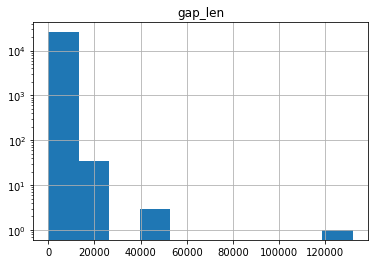

In [ ]:
ta_gaps.to_pandas().hist(column="gap_len")
plt.yscale('log')

## Interactive histograms

In [ ]:
all_vars = gap_stat.select(pl.col("variable").unique().sort()).collect()["variable"]

In [ ]:
@interact(var = all_vars)
def plot_var_dist(var):
    ta_gaps = gap_stat.filter(
        pl.col("variable") == var 
    ).collect().to_pandas().hist("gap_len")
    plt.yscale('log') 
    plt.title(var)

interactive(children=(Dropdown(description='var', options=('CO2_F_MDS_QC', 'G_F_MDS_QC', 'H_F_MDS_QC', 'LE_F_M…

In [ ]:
all_sites = gap_stat.select(pl.col("site").unique().sort()).collect()["site"]

In [ ]:
@interact(var = all_vars, site = all_sites)
def plot_var_dist(var, site):
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var) & (pl.col("site") == site)
    ).collect().to_pandas().hist("gap_len")
    plt.yscale('log') 
    plt.title(var)

interactive(children=(Dropdown(description='var', options=('CO2_F_MDS_QC', 'G_F_MDS_QC', 'H_F_MDS_QC', 'LE_F_M…

In [ ]:
@interact(var = all_vars, site = all_sites)
def plot_var_dist(var, site, small=False):
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var) & (pl.col("site") == site)
    ).filter(
        pl.col("gap_len") < 200 if small else True
    ).collect().to_pandas().hist("gap_len")
    plt.title(f"{site}: {var} - { 'gaps < 200' if small else 'all gaps'}")

interactive(children=(Dropdown(description='var', options=('CO2_F_MDS_QC', 'G_F_MDS_QC', 'H_F_MDS_QC', 'LE_F_M…

In [ ]:
@interact(var = all_vars)
def plot_var_dist(var, small=False):
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < 200 if small else True
    ).collect().to_pandas().hist("gap_len", bins=30)
    plt.title(f"{var} - { 'gaps < 200' if small else 'all gaps'}")
    plt.yscale('log')
    plt.xscale('log') 

interactive(children=(Dropdown(description='var', options=('CO2_F_MDS_QC', 'G_F_MDS_QC', 'H_F_MDS_QC', 'LE_F_M…

In [ ]:
from fastai.vision.data import get_grid
from pyprojroot import here

In [ ]:
def plot_var_dist(var, small=False, ax=None):
    if ax is None: ax = get_grid(1)[0]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < 200 if small else True
    ).with_column(pl.col("gap_len") / (24 *2 * 7)).collect().to_pandas().hist("gap_len", bins=50, ax=ax)
    ax.set_title(f"{var} - { 'gaps < 200' if small else 'all gaps'}")
    if not small: ax.set_yscale('log')
    ax.set_xlabel("gap length (weeks)")
    ax.set_ylabel(f"{'Log' if not small else ''} n gaps")
    # plt.xscale('log') 

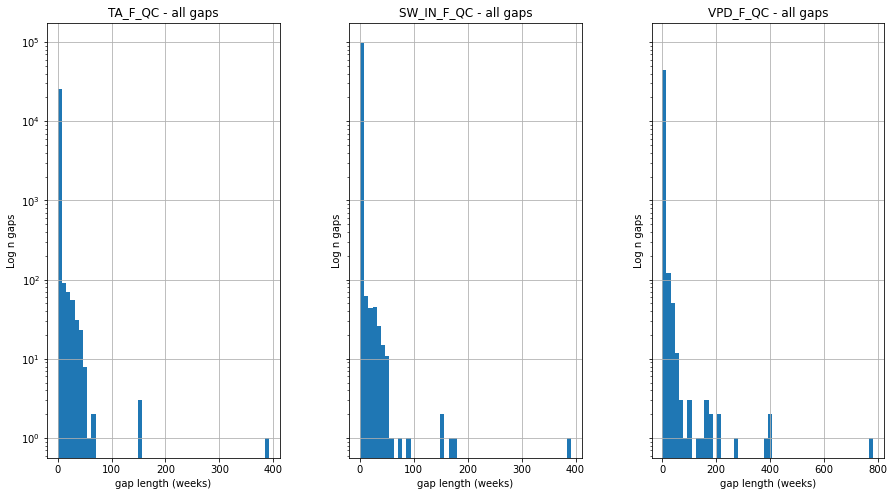

In [ ]:
for ax, var in zip(get_grid(3,1,3, figsize=(15,8), sharey=True), ['TA_F_QC', 'SW_IN_F_QC', 'VPD_F_QC']):
    plot_var_dist(var, ax=ax)
plt.savefig(here("analysis/presentations/plots_18_jan/gap_len_dist.png", warn=False))

In [ ]:
def plot_var_dist_small(var, ax=None):
    if ax is None: ax = get_grid(1)[0]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < (24 * 2 *7) 
    ).with_column(pl.col("gap_len") / (24 *2)).collect().to_pandas().hist("gap_len", bins=50, ax=ax)
    ax.set_title(f"{var} - gap len < 1 week")
    ax.set_xlabel("gap length (days)")
    ax.set_ylabel(f"Log n gaps")
    ax.set_yscale('log') 

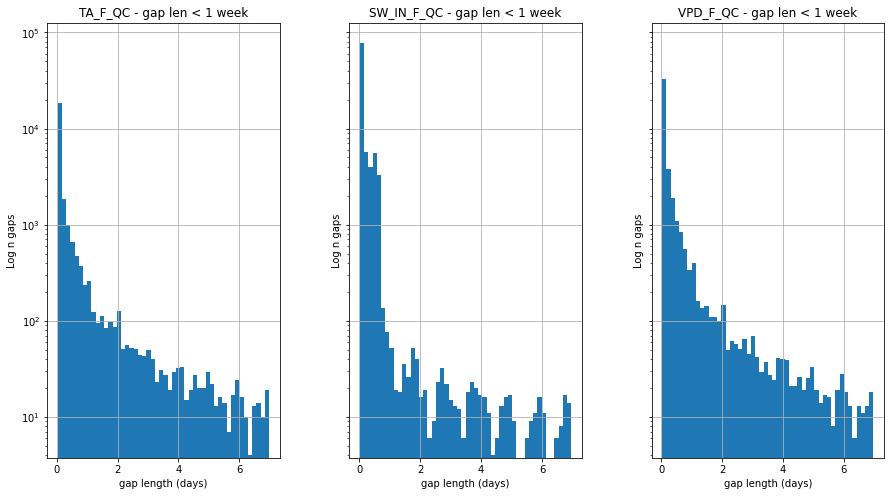

In [ ]:
for ax, var in zip(get_grid(3,1,3, figsize=(15,8), sharey=True), ['TA_F_QC', 'SW_IN_F_QC', 'VPD_F_QC']):
    plot_var_dist_small(var, ax=ax)
plt.savefig(here("analysis/presentations/plots_18_jan/gap_len_dist_small.png", warn=False))

In [ ]:
def plot_var_dist_cum(var, ax=None):
    if ax is None: ax = get_grid(1)[0]
    
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < (24 * 2 *7) 
    ).collect() #.to_pandas().hist("gap_len", bins=50, ax=ax)
    bins = pl.cut(ta_gaps["gap_len"], bins = pl.arange(0, 24 * 2 * 7, (24 * 2 * 7) // 50, eager=True))
    return ta_gaps
    ax.set_title(f"{var} - gap len < 1 week")
    ax.set_xlabel("gap length (days)")
    ax.set_ylabel(f"Log n gaps")
    ax.set_yscale('log') 

## Difference sites

In [ ]:
var_gaps = gap_stat.filter(
        (pl.col("variable") == 'TA_F_QC')
    ).filter(
        pl.col("gap_len") < 20000
    ).sort(pl.col("gap_len")
        
    ).collect().to_pandas()

In [ ]:
alt.data_transformers.enable('data_server')

In [ ]:
 
alt.Chart(var_gaps).mark_boxplot().encode(
    y=alt.Y('site', sort=alt.Sort(alt.EncodingSortField(field="y", op="mean", order="ascending"))),
    x='gap_len'
)

In [ ]:
widgets.IntSlider?

In [ ]:
@interact(var = all_vars)
def plot_var_dist(var, max_len=widgets.IntSlider(1000, 100, 20_000, 100)):
    var_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < max_len
    ).collect().to_pandas()
    
    display(alt.Chart(var_gaps).mark_boxplot().encode(
        y=alt.Y('site', sort=alt.Sort(alt.EncodingSortField(field="y", op="mean", order="ascending"))),
        x='gap_len'
    ))

In [ ]:
gap_stat.with_columns(
    (pl.col("gap_len") / pl.col("total_obs")).alias("frac_gap")
).head().collect()

In [ ]:
gap_stat.with_columns(
    (pl.col("gap_len") / pl.col("total_obs")).alias("frac_gap")
).groupby(["variable", "site"]).agg(pl.col("gap_len").sum()).head().collect()

In [ ]:
gap_stat.with_columns(
    (pl.col("gap_len") / pl.col("total_obs")).alias("frac_gap")
).groupby(["variable", "site"]).agg(
    pl.col("gap_len").sum() / pl.col("total_obs").first()
).groupby("variable").agg(pl.col("gap_len").mean()).collect()

In [ ]:
gap_stat.with_columns(
    (pl.col("gap_len") / pl.col("total_obs")).alias("frac_gap")
).groupby(["variable", "site"]).agg(
    pl.col("gap_len").sum() / pl.col("total_obs").first()
).filter(pl.col("variable") == "TA_F_QC").collect()